In [38]:
!pip install Keras-Preprocessing
!pip install nltk

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import pickle

Load Data


In [40]:
data = pd.read_csv("Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [41]:
data.shape

(568454, 10)

Data Cleaning (Handling Missing Values)


In [42]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


Remove rows which are having null values

In [43]:
data.dropna(how='any',inplace=True)

Remove duplicate rows

In [44]:
data.drop_duplicates(inplace=True, subset=['Score','Text'])

"Target" column using Score

In [45]:
## `Score` > 3 : "Positive"
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"

def create_target(x):

    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [46]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [47]:
print(data.loc[:, 'target'])

0         Positive
1         Negative
2         Positive
3         Negative
4         Positive
            ...   
568449    Positive
568450    Negative
568451    Positive
568452    Positive
568453    Positive
Name: target, Length: 393656, dtype: object


In [48]:
# target column
data[['Score', 'target']].sample(5)

,Score,target
526243,5,Positive
539124,5,Positive
18631,5,Positive
534541,5,Positive
145764,5,Positive


Handling Class Imbalance as positive is much higher than -ve and neutral.

Target distribution (Before)


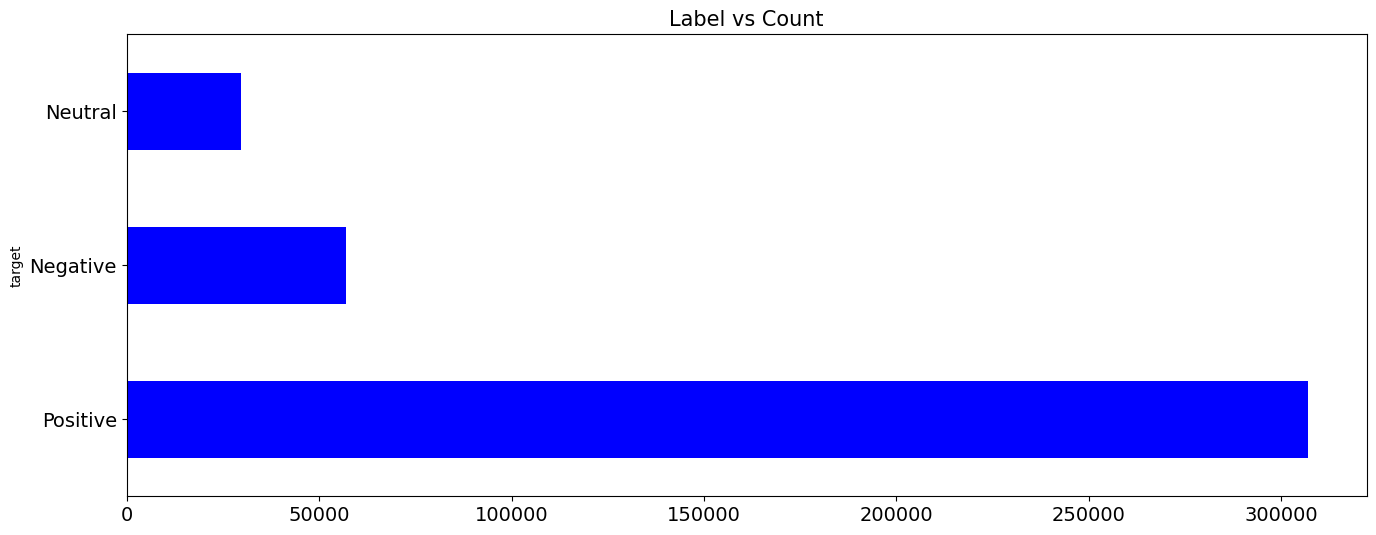

In [49]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

Down Sampling some Reviews (30k)


In [50]:
neutral = data.loc[data.target=="Neutral"].sample(10000)

positive = data.loc[data.target=="Positive"].sample(10000)

negative = data.loc[data.target=="Negative"].sample(10000)

data = pd.concat([positive, negative, neutral])
data.shape

(30000, 11)

Target distribution (After)

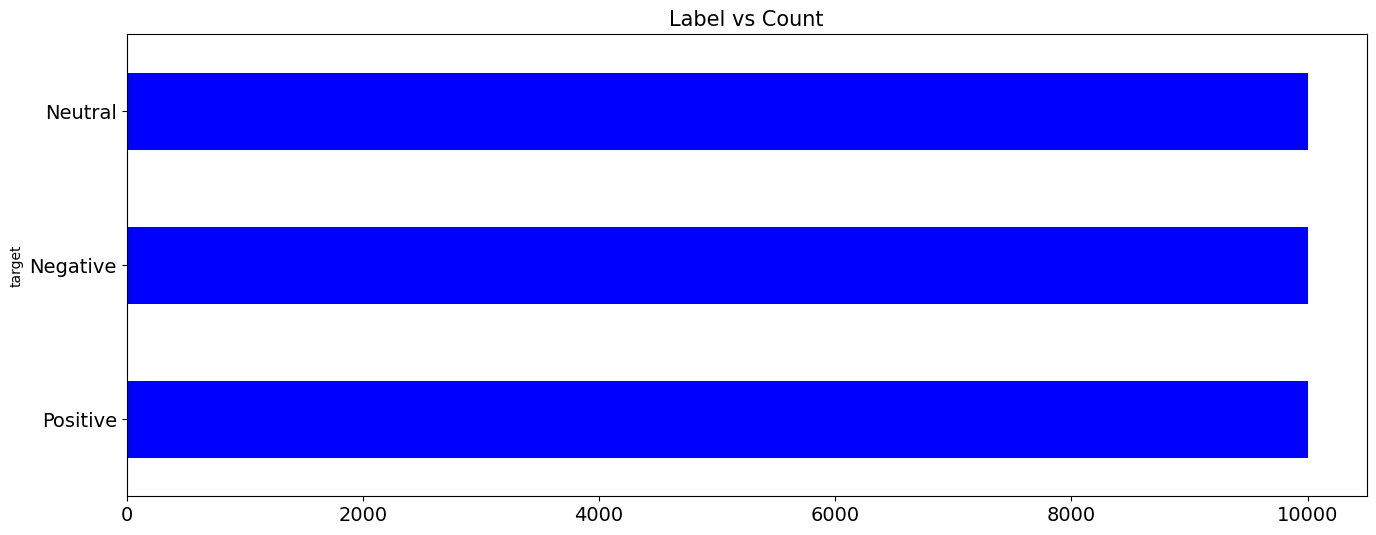

In [51]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

Data Pre-processing

In [52]:
from wordcloud import STOPWORDS
import nltk

In [53]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Stop words

In [54]:
# stopwords
total_stopwords = set(stopwords.words('english'))
print(total_stopwords)


{'further', 'being', 'hers', 'their', 'up', 'any', 'it', "weren't", 'through', 'off', 'all', 'has', 'himself', 'those', 'here', 'had', 'below', 'once', 'where', 'themselves', 'mightn', 'yours', 'shouldn', 'very', "isn't", 'not', 'out', 'its', "mustn't", 'why', 'from', 'this', 'but', 'have', 'itself', 'under', 'who', 'if', 'again', 'how', 'am', "needn't", 'wasn', 'just', 'these', 'will', "you'd", 'yourself', "shan't", 'now', 'same', "doesn't", 've', 'she', 'which', 'between', 'do', 'in', 'that', 'o', 'our', 'at', 'doing', 'does', 'with', 'few', 't', 'aren', 'of', 'on', 'your', 'can', 'don', 'been', "hadn't", 'and', "don't", 'is', 'you', 'a', 'didn', 'only', 'couldn', 'did', "won't", 'as', 'yourselves', 'against', "it's", 'an', 'ourselves', 'doesn', 'because', 'theirs', 'we', 'other', 'down', 'both', "didn't", 're', 'be', "you've", 'about', "you're", 'when', "hasn't", 'herself', 'was', "wasn't", 'haven', 'ma', 'me', 'then', 'whom', 'until', 'no', 's', 'them', 'too', 'some', "should've", 

Remove unwanted words from reviews
Ex. html tags, punctuation, stop words, etc..

In [55]:
#stemming object
stemmer = PorterStemmer()

HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")

In [56]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)

    # remove digits
    review = review.translate(remove_digits)

    # lower case all letters
    review = review.lower()

    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()

    # remove stop words
    review = [word for word in review.split()
              if word not in total_stopwords]

    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])

    return review

In [74]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


'love ginger dont like gross ginger tea get asian import store theyr bit gingeri somehow tast bad perfect blend ginger green havent abl find anyth els like best tea youll find bag'

In [58]:
# apply preprocessing function

data.Text = data.Text.apply(preprocessor)
print("After preprocessing : ")
data.Text.iloc[6]

After preprocessing : 


'love ginger dont like gross ginger tea get asian import store theyr bit gingeri somehow tast bad perfect blend ginger green havent abl find anyth els like best tea youll find bag'

Train Test Split

Train set : 70% of data
Test set : 30% of data

In [59]:
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.30, random_state=1, stratify=y)

In [60]:
y.head()

,target
349655,Positive
295129,Positive
338746,Positive
381159,Positive
39349,Positive


In [61]:
X_train.shape, X_test.shape

((21000,), (9000,))

Vectorization
Bag of Words Vectorizer

In [62]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

Test Example of Vecoization

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

# Sample text corpus
corpus = [
    "i aa b c love pizza",
    "Pizza is delicious and  love it",
    "Do you love pizza too?",
    " enjoy pasta more than pizza",
    "Pizza and pasta are both great dishes"
]

# Create CountVectorizer with max_features=10000
vectorizer = CountVectorizer(max_features=10000)

# Fit and transform the corpus
X = vectorizer.fit_transform(corpus)

# Show the count matrix as an array (dense format)
print(X.toarray())

# Display the top 10000 features (in this case, there are fewer than 10000)
print(vectorizer.get_feature_names_out())

[[1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0]
 [0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0]]
['aa' 'and' 'are' 'both' 'delicious' 'dishes' 'do' 'enjoy' 'great' 'is'
 'it' 'love' 'more' 'pasta' 'pizza' 'than' 'too' 'you']


TF-IDF Vectorizer

In [64]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

Label Encoding


In [65]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Neutral', 'Positive']


In [66]:
print(y_train,y_test)

[0 1 0 ... 1 2 0] [1 1 2 ... 2 2 0]


Model Training

In [67]:
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print(model)
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")


Random Forest - BOW

In [68]:
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score, classification_report


# Create a Random Forest classifier
rambow = RandomForestClassifier(n_estimators=100, random_state=42)

train_and_eval(model=rambow,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)

RandomForestClassifier(random_state=42)
Test accuracy score : 0.6321111111111111



Random Forest - itfidf

In [69]:
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score, classification_report


# Create a Random Forest classifier
ramit = RandomForestClassifier(n_estimators=100, random_state=42)

train_and_eval(model=ramit,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)

RandomForestClassifier(random_state=42)
Test accuracy score : 0.6373333333333333


XGBoost - BOW

In [70]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report



# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(bow_X_train, label=y_train)
dtest = xgb.DMatrix(bow_X_test, label=y_test)

xgbowmodel = xgb.XGBClassifier(random_state=42)
train_and_eval(model=xgbowmodel,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Test accuracy score : 0.6484444444444445


XGBoost - itidf

In [72]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report



# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(bow_X_train, label=y_train)
dtest = xgb.DMatrix(bow_X_test, label=y_test)

xgbitmodel = xgb.XGBClassifier(random_state=42)
train_and_eval(model=xgbitmodel,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Test accuracy score : 0.6432222222222223


In [87]:
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

with open("xgbit.pkl", "wb") as f:
    pickle.dump(xgbitmodel, f)

In [86]:
xgbitmodel.save_model("xgbit_model.json")

In [89]:
import pickle

#Load the saved TF-IDF vectorizer and XGBoost model
with open("transformer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

with open("xgbit.pkl", "rb") as f:
    xgbitmodel = pickle.load(f)

#Preprocess new text data
new_text = ["This product is a waste of money. Don't buy this!"]  # Input text
text_tfidf = tfidf_vectorizer.transform(new_text)  # Transform the text into TF-IDF format

#Map predicted labels to sentiment categories
sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
predicted_sentiment = sentiment_map[predictions[0]]

# Prediction result
print(f"This is a {predicted_sentiment} review.")



This is a negative review.


In [83]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, accuracy_score

# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare the dataset for BERT
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt')
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding['labels'] = torch.tensor(self.labels[idx])
        return encoding

# Convert the dataset
train_dataset = SentimentDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = SentimentDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Train the model
model.train()
for epoch in range(3):  # Training for 3 epochs
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
bert_preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        bert_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Classification report for DistilBERT
print("DistilBERT Classification Report:\n", classification_report(true_labels, bert_preds))
bert_accuracy = accuracy_score(true_labels, bert_preds)
print(f"DistilBERT Accuracy: {bert_accuracy}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67      3000
           1       0.54      0.71      0.61      3000
           2       0.83      0.67      0.74      3000

    accuracy                           0.67      9000
   macro avg       0.69      0.67      0.67      9000
weighted avg       0.69      0.67      0.67      9000

DistilBERT Accuracy: 0.6678888888888889


In [84]:
# Save the fine-tuned DistilBERT model
model_save_path = './distilbert_sentiment_model'
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved at {model_save_path}")


Model and tokenizer saved at ./distilbert_sentiment_model


In [88]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Load the saved model and tokenizer
model_save_path = './distilbert_sentiment_model'
model = DistilBertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_save_path)

# Ensure the model is on the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define sentiment labels
sentiment_labels = {0: "negative", 1: "neutral", 2: "positive"}

# Function for sentiment prediction
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)
    predicted_label = sentiment_labels.get(predictions.item(), "unknown")  # Get the human-readable label
    return predicted_label

# Test prediction
text = "I hate pizza but liked this one"
prediction = predict_sentiment(text)
print(f"Predicted sentiment: {prediction}")



Predicted sentiment: neutral


In [90]:
import shutil
import os
from google.colab import files

# Define the folder you want to zip
folder_to_zip = 'distilbert_sentiment_model'  # Replace with your folder name
zip_file_name = 'distilbert_sentiment_model'  # Name for the resulting zip file

# Create a zip file
shutil.make_archive(zip_file_name[:-4], 'zip', folder_to_zip)

# Download the zip file
files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>